# Modelagem Sarima para Precipitação Mensal na Cidade de São Paulo

In [37]:
from dateutil.parser import parse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import mplcursors
from datetime import datetime

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
import warnings
warnings.filterwarnings("ignore")

### Leitura do Arquivo Original - Precipitação em $m m^3$ por mês - Base BDMEP

Importante notar que os dados foram pré-tratados através do Excel, foi realiazada uma junção entre bases automáticas e manuais, visto que a literatura indicou que não haveria mudança significativa de precipitação total entre as bases.

In [66]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [67]:
#Lendo os Dados
rainfall = pd.read_csv(r"C:\Users\Matheus Alves\Documents\git_tcc\time_series_precipitation\Dataset\dados_chuvas1.csv",parse_dates=[0], index_col=0, date_parser=parser)

In [69]:
#Amostra da Base (5 primeiros[antigos] e os 5 últimos[recentes] valores)
rainfall

,Precipitation
Date,
1984-01-31,259.3
1984-02-29,32.5
1984-03-31,54.0
1984-04-30,96.8
1984-05-31,113.0
...,...
2021-09-30,39.5
2021-10-31,91.9
2021-11-30,98.6


In [70]:
# Estatísticas Básicas
rainfall.describe()

,Precipitation
count,457.000000
mean,134.670460
std,108.082836
min,0.000000
25%,46.300000
50%,106.100000
75%,199.000000
max,607.900000


In [71]:
#Tornando Explícito as Datas de início e fim
start_date = datetime(1984,1,31)
end_date = datetime(2022,1,31)
rainfall = rainfall[start_date:end_date]

In [72]:
#Função que traça os gráficos para as séries
def plot_series(time_series):
    plt.figure(figsize=(20,8))
    plt.plot(time_series)
    plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)
    plt.ylabel('Precipitação ($mm$)', fontsize=16)
    #mplcursors.cursor(hover=True)
    #Gera uma linha indicando novo ano, fortalecendo a suspeita de sasonalidade da população
    for year in range(start_date.year,end_date.year):
        plt.axvline(pd.to_datetime('31-1-' + str(year)), color='k', linestyle='--', alpha=0.2)

In [73]:
#Função que traça os gráficos de autocorrelação ACF e PACF
def plot_corr(time_series):
    fig, axes = plt.subplots(1,2,figsize=(16,5), dpi= 300)
    plot_acf(time_series, lags=24, ax=axes[0])
    plot_pacf(time_series, lags=24, ax=axes[1])
    plt.show()

In [74]:
# Realizando Teste ADF 
def stationarity_check(time_series):
    result = adfuller(time_series)
    print(f'Estatísticas ADF : {result[0]}')
    print(f'p-valor: {result[1]}')
    print("Valores Críticos:\n")
    for key, value in result[4].items():
        print(f'{key}: {value}')

## Traçando a Série Inicial

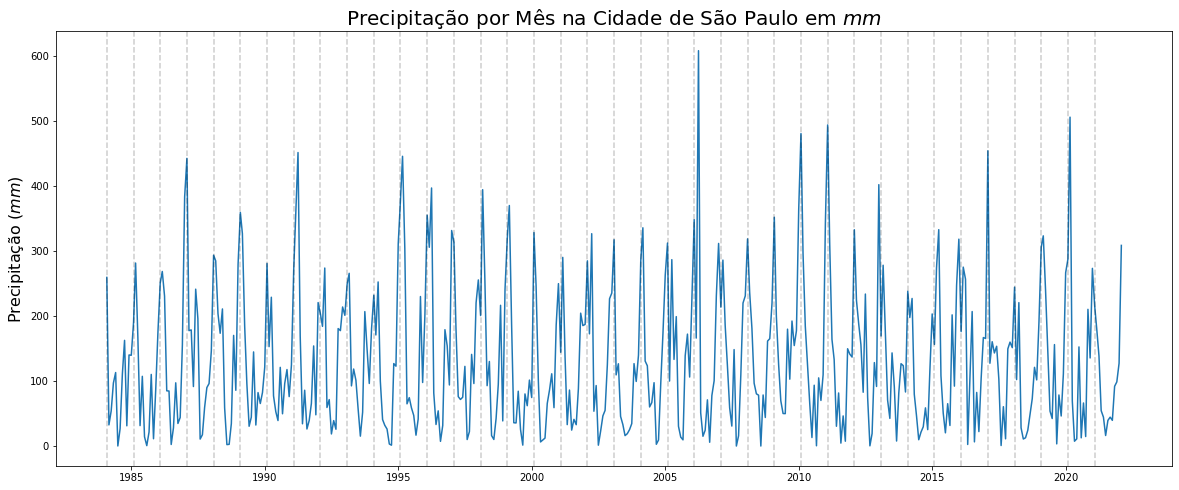

In [75]:
plot_series(rainfall) #Traça o gráfico da séries como ela é, sem transforamação.

In [76]:
stationarity_check(rainfall)

Estatísticas ADF : -4.506001282637859
p-valor: 0.0001917879351290753
Valores Críticos:

1%: -3.4451642100030084
5%: -2.8680716196949327
10%: -2.5702491139112085


A hipótese nula é rejeitada sendo que o p-valor é menor que o nível de significância 1%, portanto, de acordo com o test ADF podemos considerar essa série como estacionária, porém, vamos analisar também pela pdarima se existe necessidade de diferenciação sazonal.


## Avaliando se Existe a Necessidade de Diverenciação Sazonal através da biblioteca pdarima

In [77]:
from pmdarima.arima import nsdiffs, ndiffs

In [78]:
nsdiffs(rainfall,12) #verificando se existe a necessidade de diferenciação para m = 12

0

## Gerando os gráficos ACF e PACF inciais

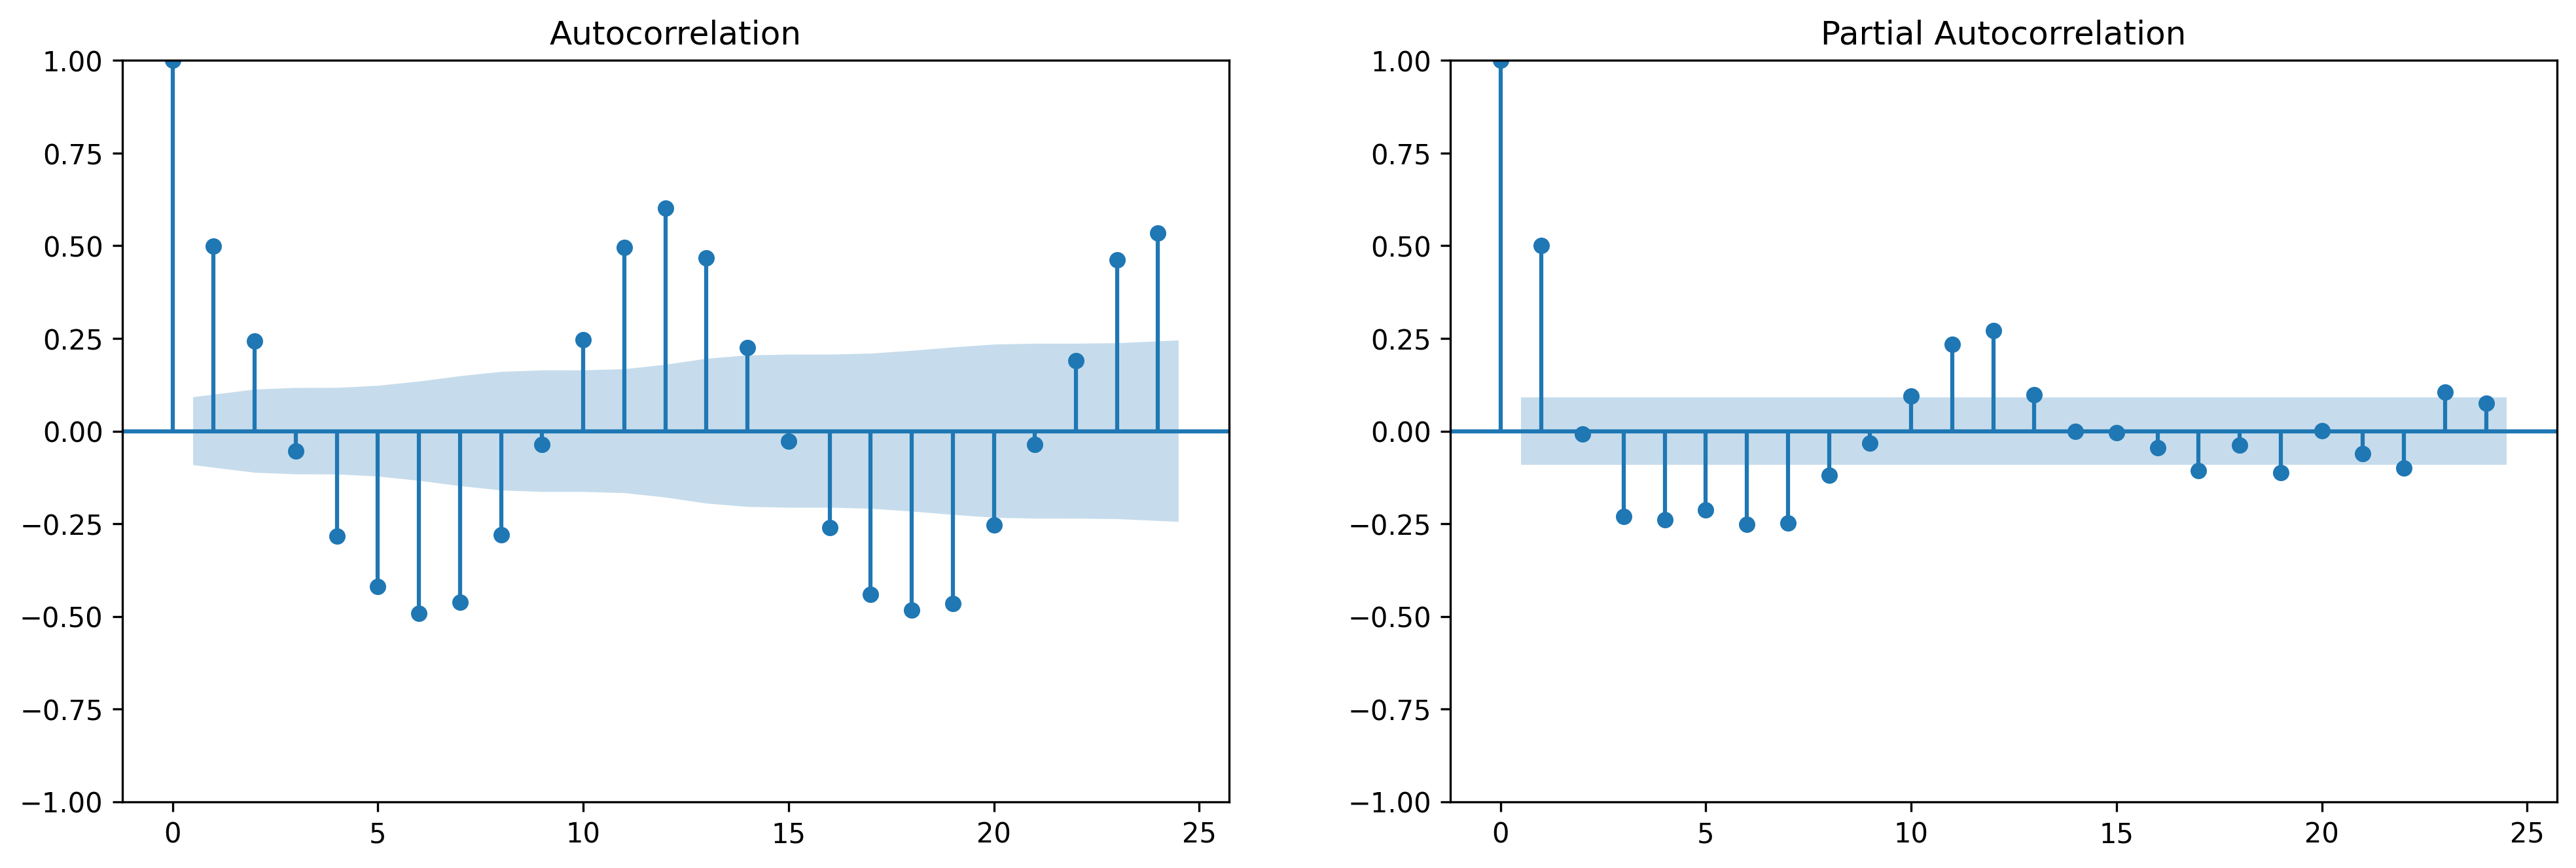

In [79]:
plot_corr(rainfall) #Traça os gráficos para ACF e PACF

## Dividindo o _dataset_ em dois diferentes conjuntos: treino e teste

O próximo passo será dividir o dataset em um cojunto de treino, que terá a maior parte do conjunto e uma parte de treino, de apenas um ano, uma vez que _forecasting_ para valores mais próximos costuma gerar resultados melhores.


In [96]:
# Treino = De 1984 até Dez/2020 e Teste de Dez/2020 até Jan/2022 
train, test = rainfall.iloc[:-14], rainfall.iloc[-15:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], rainfall.shape[0]))

In [97]:
train.shape, x_train.shape, test.shape, x_test.shape

((443, 1), (443,), (15, 1), (14,))

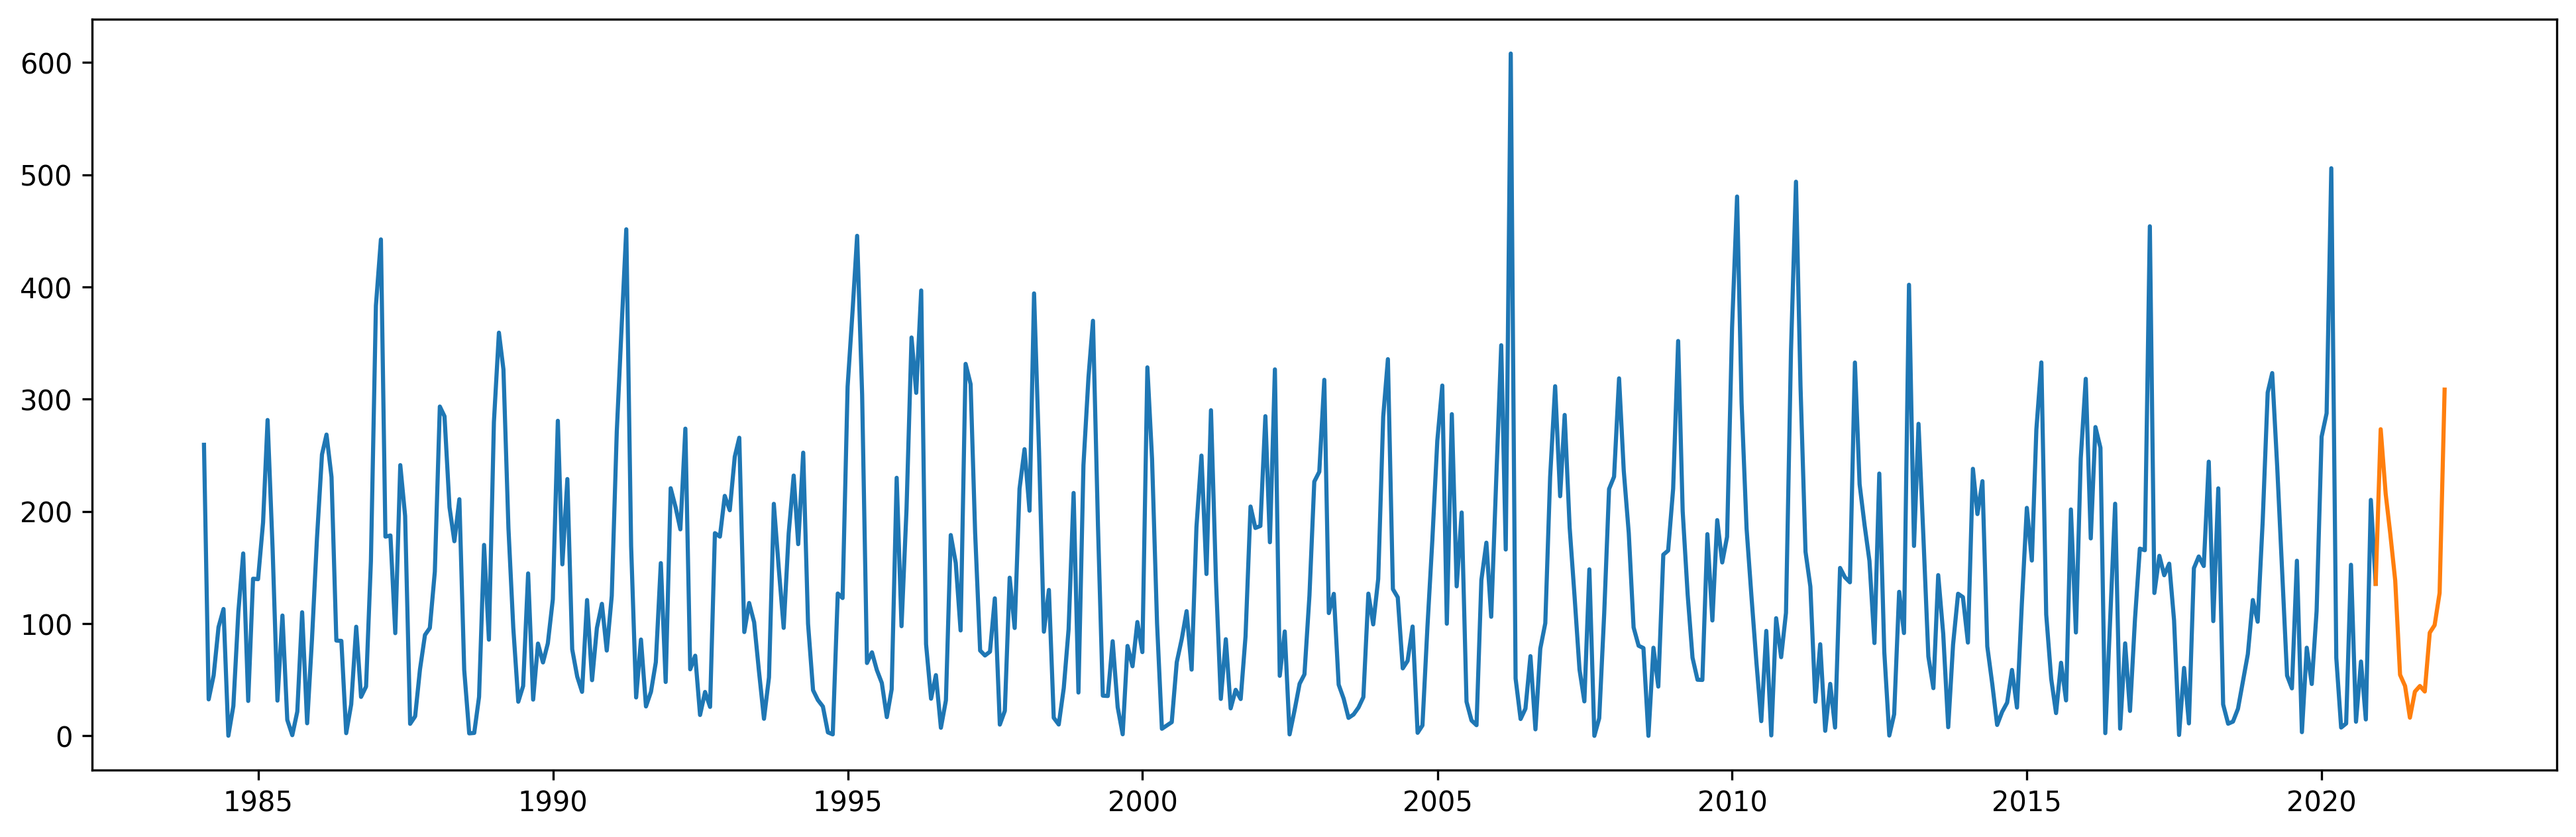

In [99]:
fig, axes = plt.subplots(1,1,figsize=(16,5), dpi= 300)
plt.plot(train)
plt.plot(test)
plt.show()

Note to Myself: Delete This Later

(S)ARIMA (1, 0, 0)x(P, 0, Q)12

We find optimum features or order of the AR(p) process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features.

We find optimum features or order of the MA(q) process using the ACF plot, as being an MA process it doesn’t have seasonal and trend components so we get only the residual relationship with the lags of time series in the ACF plot. ACF acting as a partial plot. from: https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8.

In [103]:
from pmdarima.arima import auto_arima

In [106]:
model = auto_arima(train,start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=12,             
                      d=0,          
                      seasonal='TRUE',   
                      start_P=1, 
                      start_Q=1,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5413.264, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5200.344, Time=0.45 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5247.881, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5826.462, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5289.183, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=5173.162, Time=1.87 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=5123.387, Time=2.28 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=5086.846, Time=0.82 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=5234.790, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=5121.878, Time=2.05 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=5225.387, Time=1.02 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5087.359, Time=0.77 sec
 ARIMA(2,0,0)(1,0,1)[12] inte

In [107]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  443
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -2538.423
Date:                              Tue, 26 Apr 2022   AIC                           5086.846
Time:                                      16:49:12   BIC                           5107.314
Sample:                                           0   HQIC                          5094.919
                                              - 443                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6599      1.057      1.571      0.116      -0.411       3.731
ar.L1          0.0792      0.043      1.824      0.068      -0.006       0.164
ar.S.L12       0.9837      0.010    101.723      0.000       0.965       1.003
ma.S.L12      -0.8663      0.040    -21.437      0.000      -0.946      -0.787
sigma2      5384.9262    277.593     19.399      0.000    4840.853    5928.999
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):               206.91
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.02
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
prediction, confint = model.predict(n_periods=15, return_conf_int=True)

In [114]:
prediction

array([211.36488083, 269.51954766, 248.48150869, 190.7812027 ,
        84.67484266,  65.74231907,  85.87350575,  59.68514168,
        48.3084502 ,  69.49509222, 119.55371429, 138.57590835,
       210.01552236, 266.96434728, 246.24757822])

In [118]:
cf= pd.DataFrame(confint)

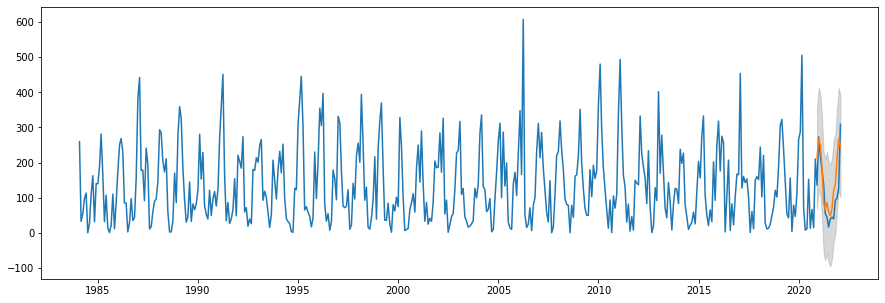

In [119]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(rainfall)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)